In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from src.dm import DFTemporalDataModule

trans = {
	'RandomRotate90': {
		'p': 0.5
	},
	'HorizontalFlip': {
		'p': 0.5
	},
	'VerticalFlip': {
		'p': 0.5
	},
}
# dm = RGBTemporalDataModule(val_size=0.2, batch_size=1, train_trans=trans)
# months = ["September", "October"]
dm = DFTemporalDataModule(batch_size=1, train_trans=trans)
dm.setup()

train: 8689
test: 2773


In [7]:
dl = dm.train_dataloader()
s1s, s2s, labels = next(iter(dl))

s1s.shape, s1s.dtype, s1s.max(), s1s.min(), s2s.shape, s2s.dtype, s2s.max(), s2s.min(), labels.shape

(torch.Size([1, 12, 2, 256, 256]),
 torch.float32,
 tensor(0.9882),
 tensor(-0.),
 torch.Size([1, 12, 3, 256, 256]),
 torch.float32,
 tensor(1.),
 tensor(0.),
 torch.Size([1, 256, 256]))

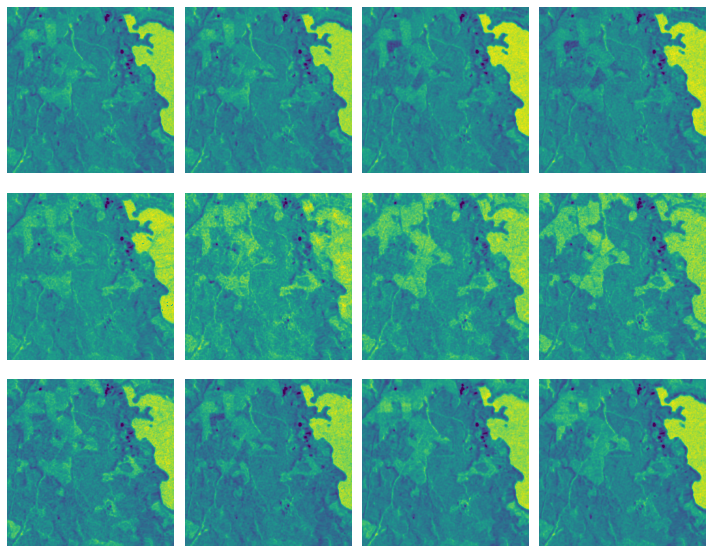

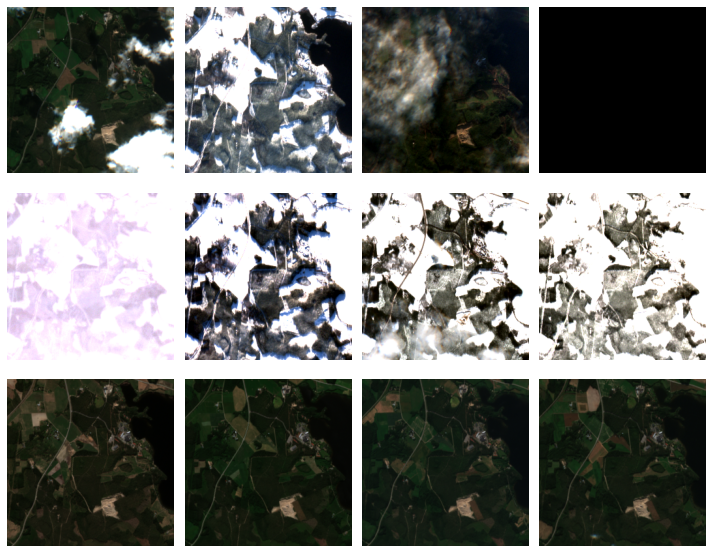

In [15]:
import matplotlib.pyplot as plt 

# dl = dm.train_dataloader(shuffle=False)
dl = dm.train_dataloader()
s1s, s2s, labels = next(iter(dl))

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(s1s[0][i*4+j][0])
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(s2s[0][i*4+j].permute(1, 2, 0))
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

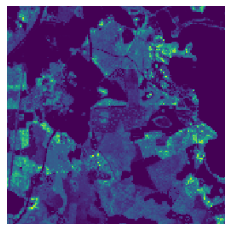

In [16]:
plt.imshow(labels[0])
plt.axis('off')
plt.show()

In [17]:
from src.module import UnetTemporalDF
import torch 

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'seq_len': 12,
}

module = UnetTemporalDF(hparams)

inputs1 = torch.randn(4, 12, 2, 256, 256)
inputs2 = torch.randn(4, 12, 3, 256, 256)

outputs = module(inputs1, inputs2)
outputs.shape

torch.Size([4, 256, 256])

In [18]:
import pytorch_lightning as pl

dm = DFTemporalDataModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'seq_len': 12,
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
	# 'scheduler': {
	# 	'OneCycleLR': {
	# 		'max_lr': 1e-2,
	# 		'pct_start': 0.1,
	# 		'total_steps': 1000,
	# 		# 'verbose': True
	# 	}
	# }
}

module = UnetTemporalDF(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=500,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | ResNetEncoder    | 11.2 M
1 | encoder2          | ResNetEncoder    | 11.2 M
2 | decoder           | UnetDecoder      | 48.5 M
3 | segmentation_head | SegmentationHead | 145   
-------------------------------------------------------
70.9 M    Trainable params
0         Non-trainable params
70.9 M    Total params
141.725   Total estimated model params size (MB)
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers 

Training: 0it [00:00, ?it/s]

In [19]:
dl = dm.train_dataloader(shuffle=False)
s1s, s2s, labels = next(iter(dl))
preds = module.predict(s1s, s2s)

preds.shape, preds.dtype, preds.min(), preds.max()

(torch.Size([4, 256, 256]), torch.float32, tensor(8.2237e-05), tensor(0.0384))

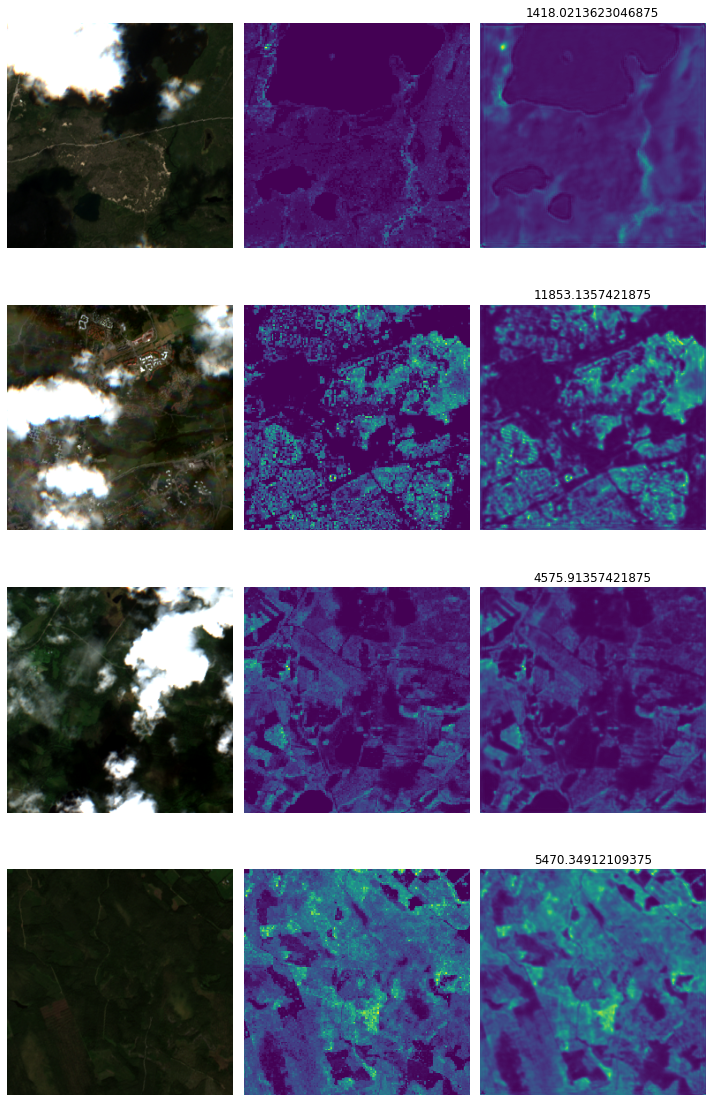

In [20]:
import torch 

fig, ax = plt.subplots(4, 3, figsize=(10, 16))
for i in range(4):
	ax[i, 0].imshow(s2s[i][-1].permute(1, 2, 0))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(labels[i])
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
	ax[i, 2].set_title(torch.sqrt(
            torch.sum((preds[i]*12905.3 - labels[i]*12905.3)**2)).item())
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd 

train = pd.read_csv('data/train.csv')
train

,Unnamed: 0,filename,chip_id,satellite,month,corresponding_agbm
0,0,0003d2eb_S1_00.tif,0003d2eb,S1,September,0003d2eb_agbm.tif
1,1,0003d2eb_S1_01.tif,0003d2eb,S1,October,0003d2eb_agbm.tif
2,2,0003d2eb_S1_02.tif,0003d2eb,S1,November,0003d2eb_agbm.tif
3,3,0003d2eb_S1_03.tif,0003d2eb,S1,December,0003d2eb_agbm.tif
4,4,0003d2eb_S1_04.tif,0003d2eb,S1,January,0003d2eb_agbm.tif
...,...,...,...,...,...,...
189073,252398,fff05995_S2_07.tif,fff05995,S2,April,fff05995_agbm.tif
189074,252399,fff05995_S2_08.tif,fff05995,S2,May,fff05995_agbm.tif
189075,252400,fff05995_S2_09.tif,fff05995,S2,June,fff05995_agbm.tif
189076,252401,fff05995_S2_10.tif,fff05995,S2,July,fff05995_agbm.tif


In [18]:
train_s1 = train[train.satellite == 'S1']
train_s2 = train[train.satellite == 'S2']

In [19]:
grouped_s1 = train_s1.groupby('chip_id').agg(list)[['filename', 'month', 'corresponding_agbm']]
grouped_s1

,filename,month,corresponding_agbm
chip_id,,,
0003d2eb,"[0003d2eb_S1_00.tif, 0003d2eb_S1_01.tif, 0003d...","[September, October, November, December, Janua...","[0003d2eb_agbm.tif, 0003d2eb_agbm.tif, 0003d2e..."
000aa810,"[000aa810_S1_00.tif, 000aa810_S1_01.tif, 000aa...","[September, October, November, December, Janua...","[000aa810_agbm.tif, 000aa810_agbm.tif, 000aa81..."
000d7e33,"[000d7e33_S1_00.tif, 000d7e33_S1_01.tif, 000d7...","[September, October, November, December, Janua...","[000d7e33_agbm.tif, 000d7e33_agbm.tif, 000d7e3..."
00184691,"[00184691_S1_00.tif, 00184691_S1_01.tif, 00184...","[September, October, November, December, Janua...","[00184691_agbm.tif, 00184691_agbm.tif, 0018469..."
001b0634,"[001b0634_S1_00.tif, 001b0634_S1_01.tif, 001b0...","[September, October, November, December, Janua...","[001b0634_agbm.tif, 001b0634_agbm.tif, 001b063..."
...,...,...,...
ffc563f4,"[ffc563f4_S1_00.tif, ffc563f4_S1_01.tif, ffc56...","[September, October, November, December, Janua...","[ffc563f4_agbm.tif, ffc563f4_agbm.tif, ffc563f..."
ffc730b9,"[ffc730b9_S1_00.tif, ffc730b9_S1_01.tif, ffc73...","[September, October, November, December, Janua...","[ffc730b9_agbm.tif, ffc730b9_agbm.tif, ffc730b..."
ffc7d4f2,"[ffc7d4f2_S1_00.tif, ffc7d4f2_S1_01.tif, ffc7d...","[September, October, November, December, Janua...","[ffc7d4f2_agbm.tif, ffc7d4f2_agbm.tif, ffc7d4f..."


In [20]:
grouped_s2 = train_s1.groupby('chip_id').agg(list)[['filename', 'month', 'corresponding_agbm']]
grouped_s2

,filename,month,corresponding_agbm
chip_id,,,
0003d2eb,"[0003d2eb_S1_00.tif, 0003d2eb_S1_01.tif, 0003d...","[September, October, November, December, Janua...","[0003d2eb_agbm.tif, 0003d2eb_agbm.tif, 0003d2e..."
000aa810,"[000aa810_S1_00.tif, 000aa810_S1_01.tif, 000aa...","[September, October, November, December, Janua...","[000aa810_agbm.tif, 000aa810_agbm.tif, 000aa81..."
000d7e33,"[000d7e33_S1_00.tif, 000d7e33_S1_01.tif, 000d7...","[September, October, November, December, Janua...","[000d7e33_agbm.tif, 000d7e33_agbm.tif, 000d7e3..."
00184691,"[00184691_S1_00.tif, 00184691_S1_01.tif, 00184...","[September, October, November, December, Janua...","[00184691_agbm.tif, 00184691_agbm.tif, 0018469..."
001b0634,"[001b0634_S1_00.tif, 001b0634_S1_01.tif, 001b0...","[September, October, November, December, Janua...","[001b0634_agbm.tif, 001b0634_agbm.tif, 001b063..."
...,...,...,...
ffc563f4,"[ffc563f4_S1_00.tif, ffc563f4_S1_01.tif, ffc56...","[September, October, November, December, Janua...","[ffc563f4_agbm.tif, ffc563f4_agbm.tif, ffc563f..."
ffc730b9,"[ffc730b9_S1_00.tif, ffc730b9_S1_01.tif, ffc73...","[September, October, November, December, Janua...","[ffc730b9_agbm.tif, ffc730b9_agbm.tif, ffc730b..."
ffc7d4f2,"[ffc7d4f2_S1_00.tif, ffc7d4f2_S1_01.tif, ffc7d...","[September, October, November, December, Janua...","[ffc7d4f2_agbm.tif, ffc7d4f2_agbm.tif, ffc7d4f..."


In [21]:
months = ["September", "October", "November", "December", "January", "February", "March", "April", "May", "June", "July", "August"]
filenames_s1 = []
for chip_id, group in grouped_s1.iterrows():
	filenames_s1.append([None]*len(months))
	for i,m in enumerate(months):
		if m in group.month:
			filenames_s1[-1][i] = group.filename[group.month.index(m)]

In [22]:
filenames_s2 = []
for chip_id, group in grouped_s1.iterrows():
	filenames_s2.append([None]*len(months))
	for i,m in enumerate(months):
		if m in group.month:
			filenames_s2[-1][i] = group.filename[group.month.index(m)]

In [24]:
filenames = [(f1, f2) for f1, f2 in zip(filenames_s1, filenames_s2)]
df = pd.DataFrame({
	'filenames': filenames,
	'corresponding_agbm': grouped_s1.corresponding_agbm.apply(lambda x: x[0])
}, index=grouped_s1.index)
df

,filenames,corresponding_agbm
chip_id,,
0003d2eb,"([0003d2eb_S1_00.tif, 0003d2eb_S1_01.tif, 0003...",0003d2eb_agbm.tif
000aa810,"([000aa810_S1_00.tif, 000aa810_S1_01.tif, 000a...",000aa810_agbm.tif
000d7e33,"([000d7e33_S1_00.tif, 000d7e33_S1_01.tif, 000d...",000d7e33_agbm.tif
00184691,"([00184691_S1_00.tif, 00184691_S1_01.tif, 0018...",00184691_agbm.tif
001b0634,"([001b0634_S1_00.tif, 001b0634_S1_01.tif, 001b...",001b0634_agbm.tif
...,...,...
ffc563f4,"([ffc563f4_S1_00.tif, ffc563f4_S1_01.tif, ffc5...",ffc563f4_agbm.tif
ffc730b9,"([ffc730b9_S1_00.tif, ffc730b9_S1_01.tif, ffc7...",ffc730b9_agbm.tif
ffc7d4f2,"([ffc7d4f2_S1_00.tif, ffc7d4f2_S1_01.tif, ffc7...",ffc7d4f2_agbm.tif
